## Phase frequency trend 

In [1]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/validation


In [2]:
import numpy as np
import scipy as sc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from scipy import signal

In [3]:
def theta1_cal( pc1, pc2 ):
    theta1           =  np.zeros(pc2.size)
    angle180         =  np.arctan2(-pc2, -pc1) * 180 / np.pi
    indNeg           =  np.where(angle180<0)[0]
    angle360         = angle180
    angle360[indNeg] = angle180[indNeg] + 360
    theta1           = np.around( ( angle360 + 22.5 ) * 8 / 360 )
    return theta1

def seas_separate(theta1_rmm,amp1_rmm,s_year,e_year):
    ph1=theta1_rmm.loc[str(s_year)+'-11-01':str(e_year)+'-04-30']*1
    a1=amp1_rmm.loc[str(s_year)+'-11-01':str(e_year)+'-04-30']*1
    return ph1,a1


def phase_freq_cal(theta1_rmm,amp1_rmm,threshold,s_year,n):
    t123 = np.zeros((n,))
    t567 = np.zeros((n,))
    t78 =np.zeros((n,))
    n1   = s_year
    
    for i in np.arange(n):
        a=[];p=[];
        p,a  = seas_separate(theta1_rmm,amp1_rmm,n1,n1+1)
        k    = np.where(a<threshold)[0]
        p[k] = 0  
        t123[i] = np.size(np.where(p==1)[0])+np.size(np.where(p==2)[0])+np.size(np.where(p==3)[0])
        t567[i] = np.size(np.where(p==4)[0])+np.size(np.where(p==5)[0])+np.size(np.where(p==6)[0])
        t78[i] = np.size(np.where(p==7)[0])+np.size(np.where(p==8)[0])

        n1 = n1+1
        
    return t123,t567,t78

def tot_phase(theta1_rmm,amp1_rmm,threshold,s_year,n):
    tt = np.zeros((n,))
    n1   = s_year
    for i in np.arange(n):
        a=[];p=[];
        p,a  = seas_separate(theta1_rmm,amp1_rmm,n1,n1+1)
        k    = np.where(a<threshold)[0]
        p[k] = 0  
        tt[i] = len(np.where(p!=0)[0])
        n1= n1+1
    return tt


def lowpass_scipy(signal,sample_freq,time_period,keep_mean):
    import numpy as np
    import scipy as sc
    from scipy import fftpack
    
    lowpass_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf = 1./time_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1 = np.abs(fftfreq) >= hf  
        
        temp_fft[i1] = 0
        if not(keep_mean):
            temp_fft[0]=0
        lowpass_signal= np.real_if_close(sc.fftpack.ifft(temp_fft))
    
    return lowpass_signal

def lowpass_scipy_butter(signal1,wn,lt):
    from scipy import signal
    w = 2/lt # Normalize the frequency
    b, a = signal.butter(wn, w, 'low')
    lowpass_signal = signal.filtfilt(b, a, signal1)

    return lowpass_signal


def smooth(x,window_len=11,window='hanning'):
    ##https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    output:
        the smoothed signal
        
    example:
    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

## WH04 RMM index

1.2446764180078544 0.9705816148009092 0.9707128313860562


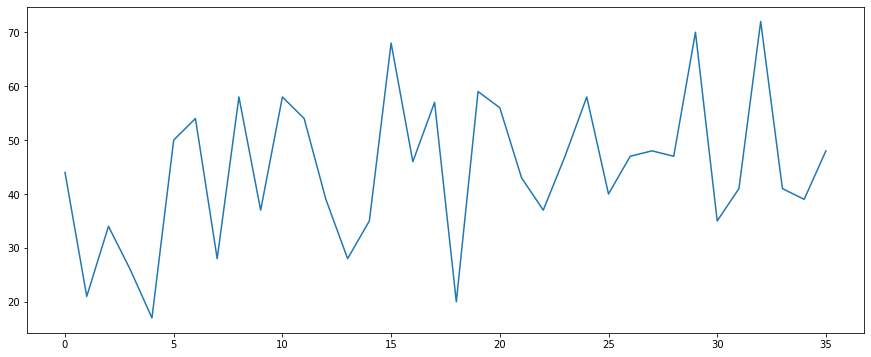

In [4]:
st = 1979 ; en = 2015 #; threshold = 1.0 ;
n = en-st;    
lf = 10;wn = 3
factor = 1.5

################################# WH04 MJO index ####################

rmm = xr.open_dataset('RMM_WH04_index_new.nc')
rmm1 = rmm['PC1'].loc[str(st)+'-01-01':str(en)+'-12-31']
rmm2 = rmm['PC2'].loc[str(st)+'-01-01':str(en)+'-12-31']

amp1_wh04 = rmm['MJO_INDEX']
phase1_wh04 = theta1_cal( rmm1, rmm2 )



# rm11 = np.real(lowpass_scipy(rmm1.values,sample_freq=1,time_period=10,keep_mean=1))
rm11 = lowpass_scipy_butter(rmm1.values,wn,lf)
rmm11 = pd.Series(rm11,index  = rmm1.time.values)

# rm22 = np.real(lowpass_scipy(rmm2.values,sample_freq=1,time_period=10,keep_mean=1))
rm22 = lowpass_scipy_butter(rmm2.values,wn,lf)
rmm22 = pd.Series(rm22,index  = rmm2.time.values)


amp1_wh04_filt = (rmm11**2+rmm22**2)**0.5
phase1_wh04_filt = theta1_cal( rmm11, rmm22 )


threshold_wh04 = np.std(amp1_wh04_filt.loc['1979-01-01':'2008-12-31'])*factor
tt_wh04 = tot_phase(phase1_wh04_filt,amp1_wh04_filt,threshold_wh04,st,n)
t123_wh04,t567_wh04,t78_wh04 = phase_freq_cal(phase1_wh04_filt,amp1_wh04_filt,threshold_wh04,st,n)

plt.figure(figsize=(15,6))
plt.plot(t567_wh04)

print(np.mean(amp1_wh04_filt),np.std(amp1_wh04_filt)*factor,amp1_wh04_filt.loc['1979-01-01':'2008-12-31'].std()*factor)

## 1905-2015

In [5]:
import pandas as pd
from scipy import stats
plt.rcParams['figure.figsize'] = (20,5)

factor = 1.5

st = 1905; en = 2015;
n= en-st


############################################# conv ######################################################################
df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm1_p1.csv')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11_conv = df11.drop('Datetime',axis=1)


df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm2.csv')

df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22_conv = df22.drop('Datetime',axis=1)

d1_conv_hist = df11_conv['rmm1'][(df11_conv.index >= datetime.datetime(st,1,1)) & (df11_conv.index  <= datetime.datetime(en,12,31))]
d2_conv_hist = df22_conv['rmm2'][(df22_conv.index >= datetime.datetime(st,1,1)) & (df22_conv.index  <= datetime.datetime(en,12,31))]

mjo_ind_conv_hist = (d1_conv_hist**2+d2_conv_hist**2)**0.5

phase1_conv_hist = theta1_cal( d1_conv_hist, d2_conv_hist )
amp1_conv_hist = mjo_ind_conv_hist *1
threshold_c = np.std(amp1_conv_hist.loc['1979-01-01':'2008-12-31'])*factor
t123_conv_hist, t567_conv_hist,_ = phase_freq_cal(phase1_conv_hist,amp1_conv_hist,threshold_c,st,n)




############################################## ol ##############################################################################################

df2 = pd.read_csv('/home/cccr/supriyo/panini/data/rmm_oliver_V3.csv')
df2['Datetime'] = df2.year.map(str) + '-' + df2.month.map(str) + '-'+df2.day.map(str) 
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2['IHR1'] = df2[['IHR1']]/df2['IHR1'].loc['1979-01-01':'2008-12-31'].std()
df2['IHR2'] = df2[['IHR2']]/df2['IHR2'].loc['1979-01-01':'2008-12-31'].std()


d1_ol = df2['IHR1'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]
d2_ol = df2['IHR2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_ol = (d1_ol**2+d2_ol**2)**0.5


phase1_ol_hist = theta1_cal( d1_ol, d2_ol )
amp1_ol_hist = mjo_ind_ol*1
threshold_o = np.std(amp1_ol_hist.loc['1979-01-01':'2008-12-31'])*factor

t123_ol_hist, t567_ol_hist,_ = phase_freq_cal(phase1_ol_hist,amp1_ol_hist,threshold_o,st,n)

########################################### JRA 55 ###########################################################################

stj = 1958;enj=2015;nj=enj-stj
df_jra55 = pd.read_excel('/home/cccr/supriyo/panini/filtered_data/data/jra55_mjo_index.xlsx')
df_jra55['Datetime'] = df_jra55.year.map(str) + '-' + df_jra55.month.map(str) + '-'+df_jra55.day.map(str) 
df_jra55.index = pd.to_datetime(df_jra55.Datetime)
df_jra55 = df_jra55.drop('Datetime',axis=1)

df_jra55['rmm1'] = df_jra55[['rmm1']]/df_jra55['rmm1'].loc['1979-01-01':'2008-12-31'].std()
df_jra55['rmm2'] = df_jra55[['rmm2']]/df_jra55['rmm2'].loc['1979-01-01':'2008-12-31'].std()

d1_jra = df_jra55['rmm1'][(df_jra55.index >= datetime.datetime(stj,1,1)) & (df_jra55.index  <= datetime.datetime(enj,12,31))]
d2_jra = df_jra55['rmm2'][(df_jra55.index >= datetime.datetime(stj,1,1)) & (df_jra55.index  <= datetime.datetime(enj,12,31))]

mjo_ind_jra = (d1_jra**2+d2_jra**2)**0.5


phase1_jra_hist = theta1_cal( d1_jra, d2_jra )
amp1_jra_hist = mjo_ind_jra.loc[str(stj)+'-01-01':str(enj)+'-12-31']
threshold_j = np.std(amp1_jra_hist.loc['1979-01-01':'2008-12-31'])*factor

t123_jra_hist, t567_jra_hist,_ = phase_freq_cal(phase1_jra_hist,amp1_jra_hist,threshold_j,stj,nj)

################################################# mlr ###################################################################

df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm1_MLR_org.txt')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11 = df11.drop('Datetime',axis=1)
df11 = df11[['rmm1']]/df11['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm2_MLR_org.txt')
df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22 = df22.drop('Datetime',axis=1)
df22 = df22[['rmm2']]/df22['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_mlr = df11['rmm1'][(df11.index >= datetime.datetime(st,1,1)) & (df11.index  <= datetime.datetime(en,12,31))]
d2_mlr = df22['rmm2'][(df22.index >= datetime.datetime(st,1,1)) & (df22.index  <= datetime.datetime(en,12,31))]

mjo_ind_mlr = (d1_mlr**2+d2_mlr**2)**0.5

phase1_mlr_hist = theta1_cal( d1_mlr, d2_mlr )
amp1_mlr_hist = mjo_ind_mlr.loc[str(st)+'-01-01':str(en)+'-12-31']
threshold_mlr = np.std(amp1_mlr_hist.loc['1979-01-01':'2008-12-31'])*factor
t123_mlr_hist, t567_mlr_hist,_ = phase_freq_cal(phase1_mlr_hist,amp1_mlr_hist,threshold_mlr,st,n)


###################################################### svr #########################################################
df_svr11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm1_1905_2015_svr_org_new.txt')

df_svr11.columns = ['Datetime','rmm1']
df_svr11.index = pd.to_datetime(df_svr11.Datetime)
df_svr11 = df_svr11.drop('Datetime',axis=1)
df_svr11 = df_svr11[['rmm1']]/df_svr11['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df_svr22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm2_1905_2015_svr_org_new.txt')
df_svr22.columns = ['Datetime','rmm2']
df_svr22.index = pd.to_datetime(df_svr22.Datetime)
df_svr22 = df_svr22.drop('Datetime',axis=1)
df_svr22 = df_svr22[['rmm2']]/df_svr22['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_svr = df_svr11['rmm1'][(df_svr11.index >= datetime.datetime(st,1,1)) & (df_svr11.index  <= datetime.datetime(en,12,31))]
d2_svr = df_svr22['rmm2'][(df_svr22.index >= datetime.datetime(st,1,1)) & (df_svr22.index  <= datetime.datetime(en,12,31))]

mjo_ind_svr = (d1_svr**2+d2_svr**2)**0.5

phase1_svr_hist = theta1_cal( d1_svr, d2_svr )
amp1_svr_hist = mjo_ind_svr.loc[str(st)+'-01-01':str(en)+'-12-31']
threshold_svr = np.std(amp1_svr_hist.loc['1979-01-01':'2008-12-31'])*factor
t123_svr_hist, t567_svr_hist,_ = phase_freq_cal(phase1_svr_hist,amp1_svr_hist,threshold_svr,st,n)


######################################### c2d ############################################################################
df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm1_conv_minmaxscale_1905_2015.csv')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11_c2d = df11.drop('Datetime',axis=1)
df11_c2d = df11_c2d[['rmm1']]/df11_c2d['rmm1'].loc['1979-01-01':'2008-12-31'].std()



df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm2_conv_minmaxscale_1905_2015.csv')

df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22_c2d = df22.drop('Datetime',axis=1)
df22_c2d = df22_c2d[['rmm2']]/df22_c2d['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_c2d_hist = df11_c2d['rmm1'][(df11_c2d.index >= datetime.datetime(st,1,1)) & (df11_c2d.index  <= datetime.datetime(en,12,31))]
d2_c2d_hist = df22_c2d['rmm2'][(df22_c2d.index >= datetime.datetime(st,1,1)) & (df22_c2d.index  <= datetime.datetime(en,12,31))]

mjo_ind_c2d_hist = (d1_c2d_hist**2+d2_c2d_hist**2)**0.5

phase1_c2d_hist = theta1_cal( d1_c2d_hist, d2_c2d_hist )
amp1_c2d_hist = mjo_ind_c2d_hist *1
threshold_c = np.std(amp1_c2d_hist.loc['1979-01-01':'2008-12-31'])*factor
t123_c2d_hist, t567_c2d_hist,_ = phase_freq_cal(phase1_c2d_hist,amp1_c2d_hist,threshold_c,st,n)


<Figure size 360x360 with 0 Axes>

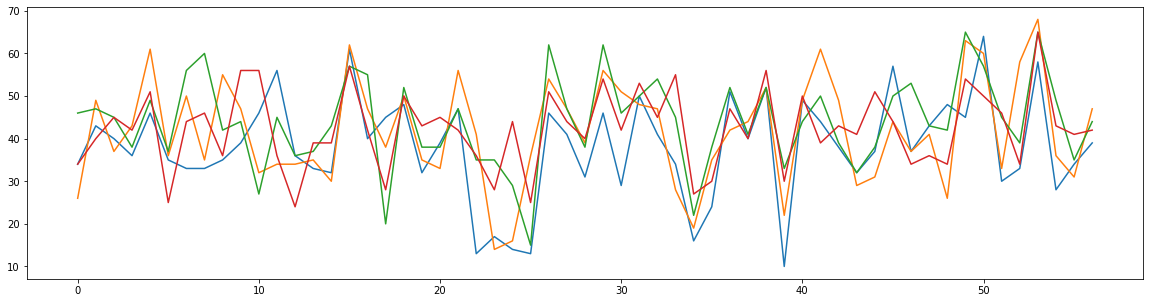

<Figure size 360x360 with 0 Axes>

In [6]:
plt.plot(t567_c2d_hist[-57:])
plt.plot(t567_mlr_hist[-57:])
plt.plot(t567_conv_hist[-57:])
plt.plot(t567_jra_hist)
np.corrcoef(t567_conv_hist[-57:],[t567_mlr_hist[-57:],t567_c2d_hist[-57:],t567_jra_hist])
plt.figure(figsize=(5,5))


## prepare a dataframe of 3 year running mean

In [7]:
df_conv = pd.DataFrame(t567_conv_hist,index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
df_ol =    pd.DataFrame(t567_ol_hist,index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
df_wh04 =  pd.DataFrame(t567_wh04,index=pd.date_range('1980-01-01',periods=36,freq='Y'),columns=['duration'])
df_mlr = pd.DataFrame(t567_mlr_hist,index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
df_svr = pd.DataFrame(t567_svr_hist,index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
df_c2d = pd.DataFrame(t567_c2d_hist,index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
df_jra = pd.DataFrame(t567_jra_hist,index=pd.date_range('1959-01-01',periods=57,freq='Y'),columns=['duration'])


df_567_all=pd.concat([df_conv,df_ol,df_wh04,df_mlr,df_svr,df_c2d,df_jra],axis=1)

In [8]:
window_len=11 ; ww = 2*(window_len//2)
yy=str(int(1906+ww/2));ll1= 110-ww;yy2=str(int(1980+ww/2));ll2=36-ww;yy3=str(int(1959+ww/2));ll3=57-ww

### different methods #######

df_conv_3yr  =   pd.DataFrame(smooth(t567_conv_hist,window_len=window_len,window='flat')[ww:-ww],index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_ol_3yr    =   pd.DataFrame(smooth(t567_ol_hist,window_len=window_len,window='flat')[ww:-ww],index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_wh04_3yr  =   pd.DataFrame(smooth(t567_wh04,window_len=window_len,window='flat')[ww:-ww],index=pd.date_range(yy2+'-01-01',periods=ll2,freq='Y'),columns=['duration'])
df_mlr_3yr   =   pd.DataFrame(smooth(t567_mlr_hist,window_len=window_len,window='flat')[ww:-ww],index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_svr_3yr   =   pd.DataFrame(smooth(t567_svr_hist,window_len=window_len,window='flat')[ww:-ww],index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_c2d_3yr   =   pd.DataFrame(smooth(t567_c2d_hist,window_len=window_len,window='flat')[ww:-ww],index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_jra_3yr   =   pd.DataFrame(smooth(t567_jra_hist,window_len=window_len,window='flat')[ww:-ww],index=pd.date_range(yy3+'-01-01',periods=ll3,freq='Y'),columns=['duration'])

df_567_all_3yr=pd.concat([df_conv_3yr,df_ol_3yr,df_wh04_3yr,df_mlr_3yr,df_svr_3yr,df_c2d_3yr,df_jra_3yr],axis=1)



## PDO index

/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


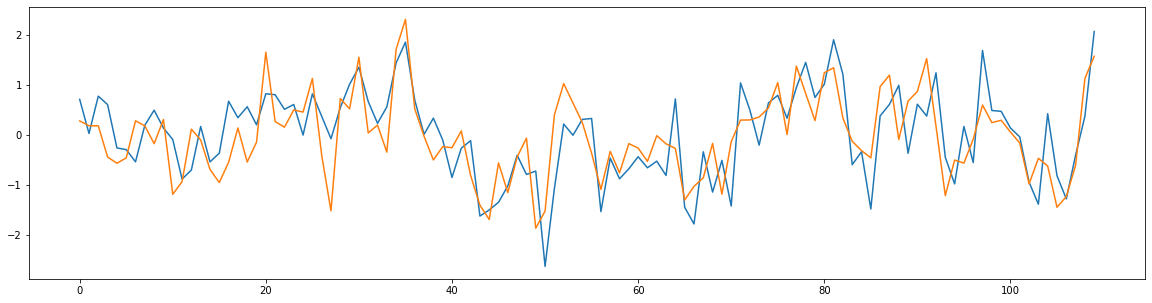

In [9]:
pdo = pd.read_csv('pdo_index.txt',sep ='   ',header = None)
pdo.columns = ['year','pdo']
pdo.index= pdo.year
pdo =pdo.drop('year',axis=1)
pdot = pdo.loc['1906':'2015']


##################################################################

pdo=pd.read_fwf('/home/cccr/roxy/panini/JGRJD_PHD_PART_I/DATA/indices/pdo/pdo_index.txt')
pdo_sel=pdo.set_index('YEAR').loc[1905:2015]
pdo_winter=pdo_sel[['JAN','FEB','MAR','APR','NOV','DEC']].values.ravel()
k=4
pdo_winter_mean=np.zeros((110,))
for i in np.arange(110):
    pdo_winter_mean[i]=np.mean(pdo_winter[k:k+6])
    k=k+6
    
plt.plot(pdo_winter_mean)
plt.plot(pdot.values)

### PDO index

pdo_winter     = pd.DataFrame(pdo_winter_mean,index =  pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
pdo_winter_3yr = pd.DataFrame(smooth(pdo_winter_mean,window_len = window_len,window='flat')[ww:-ww],index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])


## Correlation with PDO index (Table 3)

In [10]:
def detrended_timeseries():
    df_conv = pd.DataFrame(signal.detrend(t567_conv_hist),index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
    df_ol =    pd.DataFrame(signal.detrend(t567_ol_hist),index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
    df_wh04 =  pd.DataFrame(signal.detrend(t567_wh04),index=pd.date_range('1980-01-01',periods=36,freq='Y'),columns=['duration'])
    df_mlr = pd.DataFrame(signal.detrend(t567_mlr_hist),index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
    df_svr = pd.DataFrame(signal.detrend(t567_svr_hist),index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
    df_c2d = pd.DataFrame(signal.detrend(t567_c2d_hist),index=pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
    df_jra = pd.DataFrame(signal.detrend(t567_jra_hist),index=pd.date_range('1959-01-01',periods=57,freq='Y'),columns=['duration'])
    pdo_winter     = pd.DataFrame(signal.detrend(pdo_winter_mean),index =  pd.date_range('1906-01-01',periods=110,freq='Y'),columns=['duration'])
    df_all=pd.concat([df_conv,df_ol,df_wh04,df_mlr,df_svr,df_c2d,df_jra,pdo_winter],axis=1)
    
    
    window_len=11 ; ww = 2*(window_len//2)
    yy=str(int(1906+ww/2));ll1= 110-ww;yy2=str(int(1980+ww/2));ll2=36-ww;yy3=str(int(1959+ww/2));ll3=57-ww

    df_conv_3yr  =   pd.DataFrame(signal.detrend(smooth(t567_conv_hist,window_len=window_len,window='flat')[ww:-ww]),index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
    df_ol_3yr    =   pd.DataFrame(signal.detrend(smooth(t567_ol_hist,window_len=window_len,window='flat')[ww:-ww]),index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
    df_wh04_3yr  =   pd.DataFrame(signal.detrend(smooth(t567_wh04,window_len=window_len,window='flat')[ww:-ww]),index=pd.date_range(yy2+'-01-01',periods=ll2,freq='Y'),columns=['duration'])
    df_mlr_3yr   =   pd.DataFrame(signal.detrend(smooth(t567_mlr_hist,window_len=window_len,window='flat')[ww:-ww]),index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
    df_svr_3yr   =   pd.DataFrame(signal.detrend(smooth(t567_svr_hist,window_len=window_len,window='flat')[ww:-ww]),index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
    df_c2d_3yr   =   pd.DataFrame(signal.detrend(smooth(t567_c2d_hist,window_len=window_len,window='flat')[ww:-ww]),index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
    df_jra_3yr   =   pd.DataFrame(signal.detrend(smooth(t567_jra_hist,window_len=window_len,window='flat')[ww:-ww]),index=pd.date_range(yy3+'-01-01',periods=ll3,freq='Y'),columns=['duration'])

    pdo_winter_3yr = pd.DataFrame(signal.detrend(smooth(pdo_winter_mean,window_len = window_len,window='flat')[ww:-ww]),index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
    df_all_3yr=pd.concat([df_conv_3yr,df_ol_3yr,df_wh04_3yr,df_mlr_3yr,df_svr_3yr,df_c2d_3yr,df_jra_3yr,pdo_winter_3yr],axis=1)


    return df_all,df_all_3yr
    
df_all,df_all_3yr = detrended_timeseries()
df_all.corr().iloc[:,-1],df_all_3yr.corr().iloc[:,-1]


(duration   -0.130298
 duration   -0.182630
 duration   -0.428154
 duration   -0.224239
 duration   -0.186039
 duration   -0.235145
 duration   -0.127635
 duration    1.000000
 Name: duration, dtype: float64, duration   -0.407256
 duration   -0.282451
 duration   -0.219486
 duration   -0.367187
 duration   -0.339705
 duration   -0.450062
 duration   -0.280442
 duration    1.000000
 Name: duration, dtype: float64)

In [11]:
df111 = df_all.loc['1959-01-01':'2014-12-31']
df222 = df_all.loc['1980-01-01':'2014-12-31']
from scipy import stats
for i in [0,1,3,4]:
    print(stats.pearsonr(df_all.iloc[:,i].values,df_all.iloc[:,-1].values))
print(stats.pearsonr(df222.iloc[:,2].values,df222.iloc[:,-1].values))
print(stats.pearsonr(df111.iloc[:,6].values,df111.iloc[:,-1].values))


for i in [0,1,3,4]:    
    print(stats.spearmanr(df_all.iloc[:,i].values,df_all.iloc[:,-1].values))

    

print(stats.spearmanr(df222.iloc[:,2].values,df222.iloc[:,-1].values))
print(stats.spearmanr(df111.iloc[:,6].values,df111.iloc[:,-1].values))

(-0.13029795945000885, 0.17485838054357838)
(-0.18263039030577521, 0.056177491827894714)
(-0.2242386426170265, 0.018520589675635496)
(-0.1860387727754901, 0.05166372956347157)
(-0.43782278051598733, 0.008528622590841167)
(-0.12382746453130472, 0.3632201920880191)
SpearmanrResult(correlation=-0.12985145278723262, pvalue=0.17635357569968438)
SpearmanrResult(correlation=-0.19541058990600274, pvalue=0.040772244865746765)
SpearmanrResult(correlation=-0.2261659491017289, pvalue=0.01750988015326155)
SpearmanrResult(correlation=-0.17780132092058698, pvalue=0.06312223303646747)
SpearmanrResult(correlation=-0.3675070028011205, pvalue=0.029864437455684404)
SpearmanrResult(correlation=-0.10970608339029393, pvalue=0.42088751413081327)


In [12]:
df111_3yr = df_all_3yr.loc['1964-01-01':'2014-12-31']
df222_3yr = df_all_3yr.loc['1985-01-01':'2014-12-31']
from scipy import stats
for i in [0,1,3,4]:
    print(stats.pearsonr(df_all_3yr.iloc[:,i].values,df_all_3yr.iloc[:,-1].values))
    
print(stats.pearsonr(df222_3yr.iloc[:,2].values,df222_3yr.iloc[:,-1].values))
print(stats.pearsonr(df111_3yr.iloc[:,6].values,df111_3yr.iloc[:,-1].values))

for i in [0,1,3,4]:    
    print(stats.spearmanr(df_all_3yr.iloc[:,i].values,df_all_3yr.iloc[:,-1].values))

print(stats.spearmanr(df222_3yr.iloc[:,2].values,df222_3yr.iloc[:,-1].values))
print(stats.spearmanr(df111_3yr.iloc[:,6].values,df111_3yr.iloc[:,-1].values))

(-0.4072555793580433, 2.609097468197418e-05)
(-0.28245095783121016, 0.004410353015658938)
(-0.3671873800482287, 0.00017137143294358322)
(-0.33970486691272067, 0.000544676185857072)
(-0.21948623434501566, 0.2813338350278388)
(-0.2804423056954319, 0.05621626237207605)
SpearmanrResult(correlation=-0.3875667566756675, pvalue=6.781816009803457e-05)
SpearmanrResult(correlation=-0.24603660366036603, pvalue=0.013606459388444863)
SpearmanrResult(correlation=-0.374053405340534, pvalue=0.0001262577285699262)
SpearmanrResult(correlation=-0.357023702370237, pvalue=0.00026605490539106165)
SpearmanrResult(correlation=-0.20615384615384613, pvalue=0.3123081399823765)
SpearmanrResult(correlation=-0.26838575393154485, pvalue=0.06814598514481052)


In [13]:
df_all_3yr.std()/df_all.std(),df_all_3yr.std().mean()/df_all.std().mean()

(duration    0.279991
 duration    0.212244
 duration    0.130373
 duration    0.227981
 duration    0.242690
 duration    0.345987
 duration    0.129687
 duration    0.585639
 dtype: float64, 0.2325060645399399)

## PLOT the time series

/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


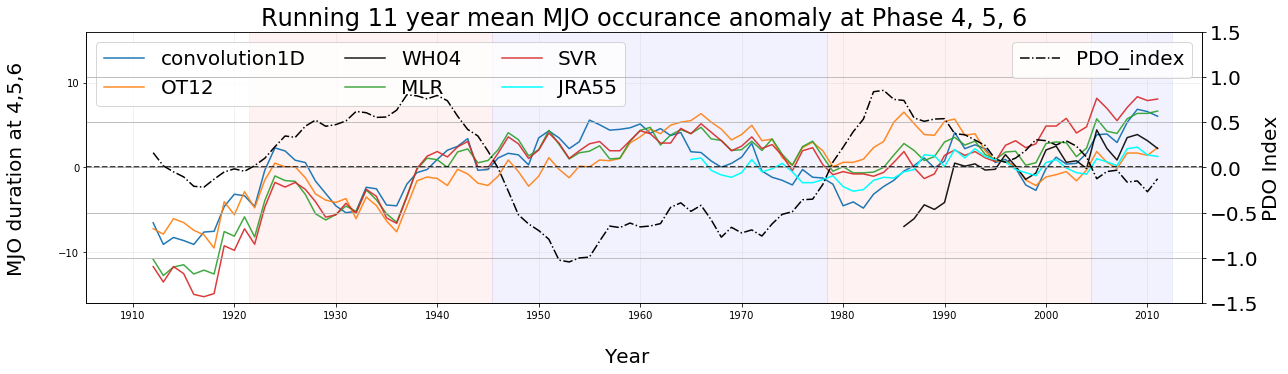

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import host_subplot

fig,ax=plt.subplots(1,1,figsize=(20,5))

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'seismic'


ax.plot(df_567_all_3yr.iloc[:,0]-df_567_all_3yr.iloc[:,0].mean(),label='convolution1D')
ax.plot(df_567_all_3yr.iloc[:,1]-df_567_all_3yr.iloc[:,1].mean(),'-',label='OT12',alpha=0.9)
ax.plot(df_567_all_3yr.iloc[:,2]-df_567_all_3yr.iloc[:,2].mean(),'k',label='WH04',alpha=0.9)
ax.plot(df_567_all_3yr.iloc[:,3]-df_567_all_3yr.iloc[:,3].mean(),'-',label='MLR',alpha=0.9)
ax.plot(df_567_all_3yr.iloc[:,4]-df_567_all_3yr.iloc[:,4].mean(),'-',label='SVR',alpha=0.9)
# ax.plot(df_567_all_3yr.iloc[:,5]-df_567_all_3yr.iloc[:,5].mean(),'-.',label='C2D',alpha=0.5,color='magenta')
ax.plot(df_567_all_3yr.iloc[:,6]-df_567_all_3yr.iloc[:,6].mean(),'-',label='JRA55',color='cyan')

ax.xaxis.set_major_locator(mdates.YearLocator(base=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True)

ax.set_ylim([-16,16])
ax.grid(linestyle='-', linewidth=.5,alpha=0.3)
ax.axhline(0,color='k',linestyle='--')
ax.set_xlim([datetime.datetime(1905,6,1),datetime.datetime(2015,6,1)])


fig.text(0.5, -0.04, 'Year', ha='center')
fig.text(0.07, 0.5, 'MJO duration at 4,5,6', va='center', rotation='vertical')
ax.axvspan(datetime.datetime(1921,6,1),datetime.datetime(1945,6,1),color = 'r',alpha = 0.05)
ax.axvspan(datetime.datetime(1945,6,1),datetime.datetime(1978,6,1),color = 'b',alpha = 0.05)
ax.axvspan(datetime.datetime(1978,6,1),datetime.datetime(2004,6,1),color = 'r',alpha = 0.05)# ax.axvspan(1998,2012,alpha = 0.1)
ax.axvspan(datetime.datetime(2004,6,1),datetime.datetime(2012,6,1),color = 'b',alpha = 0.05)



plt.legend(ncol=3)
plt.title('Running 11 year mean MJO occurance anomaly at Phase 4, 5, 6')

# plt.gcf().autofmt_xdate() # Rotation

ax2 = ax.twinx()


ax2.plot(pdo_winter_3yr-pdo_winter_3yr.mean(),'-.',label='PDO_index',color='k')
ax2.set_ylim([-1.5,1.5])
ax2.set_ylabel('PDO Index')

ax2.xaxis.set_major_locator(mdates.YearLocator(base=10))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.grid(True)

plt.legend()
plt.show()
fig.savefig('/home/cccr/supriyo/panini/very_low_jgrjd_figure6.png',dpi=300,bbox_inches='tight')

In [15]:
%store df_567_all_3yr
%store pdo_winter_3yr

Stored 'df_567_all_3yr' (DataFrame)
Stored 'pdo_winter_3yr' (DataFrame)


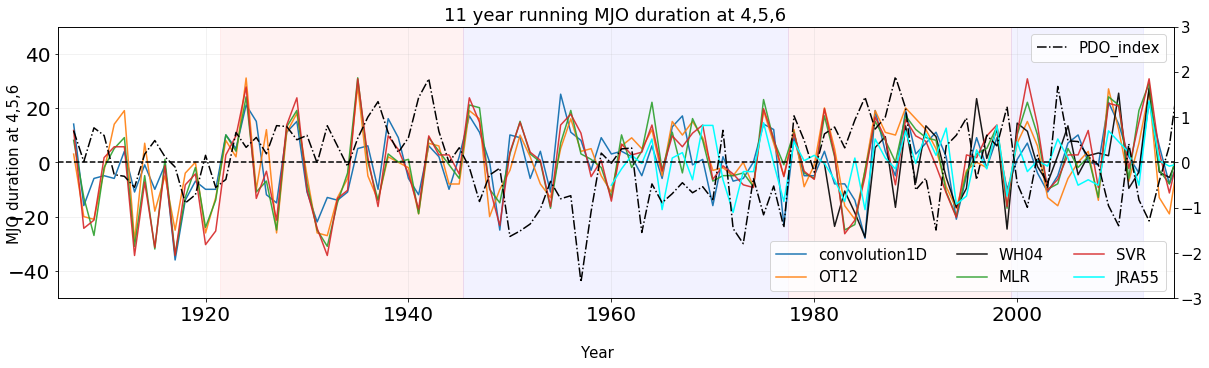

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import host_subplot

fig,ax=plt.subplots(1,1,figsize=(20,5))

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 15
plt.rcParams['image.cmap'] = 'seismic'


ax.plot(df_567_all.iloc[:,0]-df_567_all.iloc[:,0].mean(),label='convolution1D')
ax.plot(df_567_all.iloc[:,1]-df_567_all.iloc[:,1].mean(),'-',label='OT12',alpha=0.9)
ax.plot(df_567_all.iloc[:,2]-df_567_all.iloc[:,2].mean(),'k',label='WH04',alpha=0.9)
ax.plot(df_567_all.iloc[:,3]-df_567_all.iloc[:,3].mean(),'-',label='MLR',alpha=0.9)
ax.plot(df_567_all.iloc[:,4]-df_567_all.iloc[:,4].mean(),'-',label='SVR',alpha=0.9)
# ax.plot(df_567_all.iloc[:,5]-df_567_all.iloc[:,5].mean(),'-.',label='C2D',alpha=0.5,color='magenta')
ax.plot(df_567_all.iloc[:,6]-df_567_all.iloc[:,6].mean(),'-',label='JRA55',color='cyan')




ax.set_ylim([-50,50])
ax.grid(linestyle='-', linewidth=.5,alpha=0.3)
ax.axhline(0,color='k',linestyle='--')
ax.set_xlim([datetime.datetime(1905,6,1),datetime.datetime(2015,6,1)])


fig.text(0.5, -0.04, 'Year', ha='center')
fig.text(0.09, 0.5, 'MJO duration at 4,5,6', va='center', rotation='vertical')
ax.axvspan(datetime.datetime(1921,6,1),datetime.datetime(1945,6,1),color = 'r',alpha = 0.05)
ax.axvspan(datetime.datetime(1945,6,1),datetime.datetime(1977,6,1),color = 'b',alpha = 0.05)
ax.axvspan(datetime.datetime(1977,6,1),datetime.datetime(1999,6,1),color = 'r',alpha = 0.05)# ax.axvspan(1998,2012,alpha = 0.1)
ax.axvspan(datetime.datetime(1999,6,1),datetime.datetime(2012,6,1),color = 'b',alpha = 0.05)

plt.legend(ncol=3)
plt.title('11 year running MJO duration at 4,5,6')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gcf().autofmt_xdate() # Rotation

ax2 = ax.twinx()


ax2.plot(pdo_winter-pdo_winter.mean(),'-.',label='PDO_index',color='k')
ax2.set_ylim([-3,3])

plt.legend()
plt.show()


## trend in phase occurance 4,5,6

(11.065420568030833, 2.887670709627391e-18)

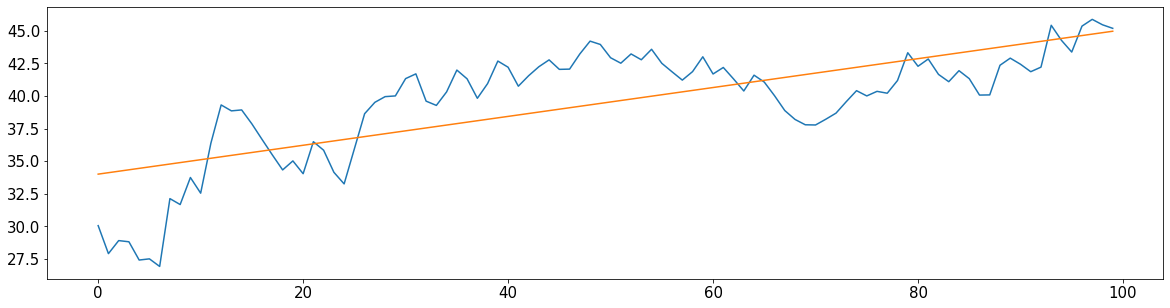

In [17]:
def trend_456():
    
    temp =df_567_all_3yr.mean(axis=1).values.squeeze()[0:]
    res,c,_,p,_  = stats.linregress(np.arange(1,len(temp)+1),temp)
    plt.plot(temp)
    plt.plot(res*np.arange(1,len(temp)+1)+c)
    return res*100,p
    
trend_456()

(11.065420568030833, 2.887670709627391e-18)

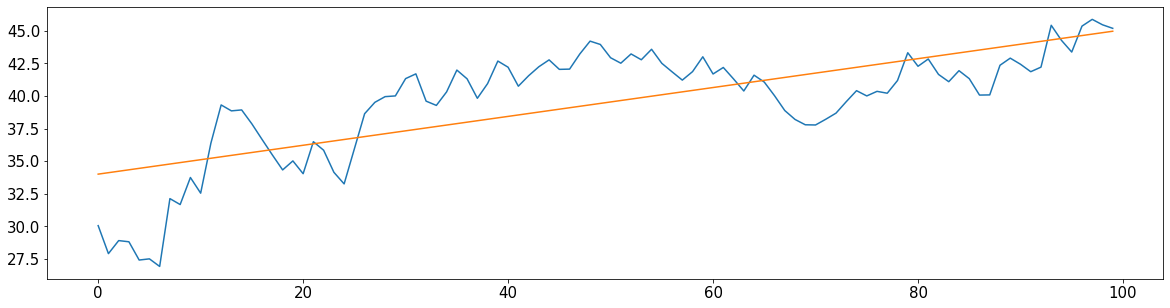

In [18]:
res,p = trend_456()
res,p

In [19]:
##########################################

LinregressResult(slope=0.06261462509887351, intercept=39.61977961432507, rvalue=0.4948728213743423, pvalue=1.6613625881925245e-07, stderr=0.011106357153189122)


LinregressResult(slope=0.08205384174781115, intercept=34.971735537190085, rvalue=0.6458472701945356, pvalue=4.005356125763921e-13, stderr=0.009798195847163366)

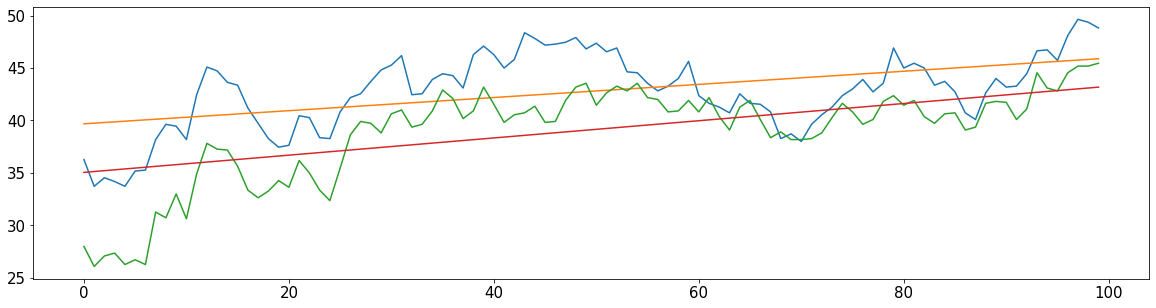

In [20]:
plt.plot(df_conv_3yr.values[0:])
res = stats.linregress(np.arange(1,len(df_conv_3yr.values[0:])+1),df_conv_3yr.values.squeeze()[0:])
plt.plot(res[0]*np.arange(1,len(df_conv_3yr.values)+1)+res[1])
print(res)
plt.plot(df_mlr_3yr.values[0:])
res = stats.linregress(np.arange(1,len(df_ol_3yr.values[0:])+1),df_ol_3yr.values.squeeze()[0:])
plt.plot(res[0]*np.arange(1,len(df_mlr_3yr.values)+1)+res[1])
res

## connection with PDO

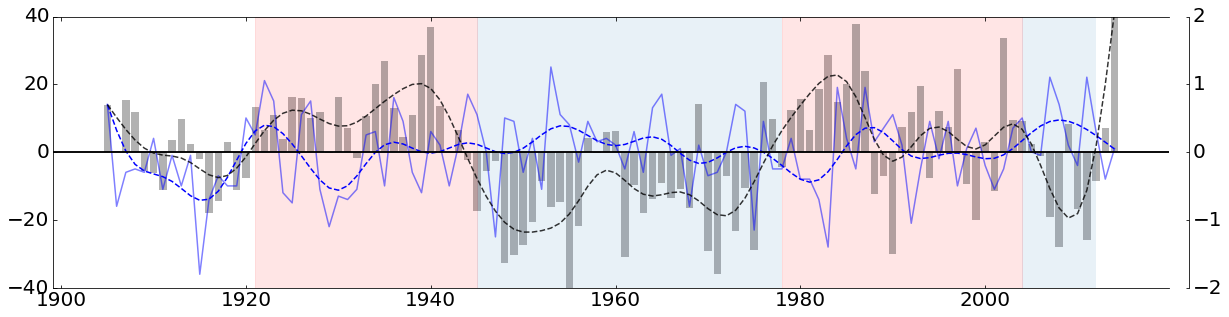

In [21]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt


plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'seismic'

host = host_subplot(111, axes_class=AA.Axes)

# plt.plot(np.arange(1905,2015,1),t567_ol)

t567_conv_detrend = signal.detrend(t567_conv_hist)
plt.plot(np.arange(1905,2015,1),t567_conv_hist-np.mean(t567_conv_hist),'b',alpha=0.5)

# t567_ol_detrend = signal.detrend(t567_ol_hist)
# plt.plot(np.arange(1905,2015,1),t567_ol_hist-np.mean(t567_ol_hist),'r',alpha=0.3)


plt.plot(np.arange(1905,2015,1),lowpass_scipy_butter(t567_conv_hist-np.mean(t567_conv_hist),wn,10),'--b')
# plt.plot(np.arange(1905,2015,1),lowpass_scipy_butter(t567_ol_detrend,wn,10),'r')
mean_1 = 0

plt.axhline(mean_1,color ='k')
plt.ylim([mean_1-40,mean_1+40])



ax2 = host.twinx()
# ax3 = host.twinx()
offset = 80
# new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
# ax3.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax3,
#                                     offset=(offset, 0))

ax2.axis["right"].toggle(all=True)

offset = 20
new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
ax2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=ax2,
                                    offset=(offset, 0))

# ax3.axis["right"].toggle(all=True)

# ax2.bar(np.arange(1905,2015,1),pdot.values[:,0],color='k',alpha=0.3)
# ax2.plot(np.arange(1905,2015,1),lowpass_scipy_butter(pdot.values[:,0],wn,10),'--k',alpha=0.8)



pdo_time_series= pdo_winter_mean*1#pdot.values.squeeze()*1
ax2.bar(np.arange(1905,2015,1),pdo_time_series-np.mean(pdo_time_series),color='k',alpha=0.3)
ax2.plot(np.arange(1905,2015,1),lowpass_scipy_butter(pdo_time_series-np.mean(pdo_time_series),wn,10),'--k',alpha=0.8)


mean_2 =0
ax2.axhline(mean_2,color ='k')
ax2.set_ylim([mean_2-2,mean_2+2])

ax2.axvspan(1921,1945,color = 'r',alpha = 0.1)
ax2.axvspan(1945,1978,alpha = 0.1)
ax2.axvspan(1978,2004,color = 'r',alpha = 0.1)
ax2.axvspan(2004,2012,alpha = 0.1)
# ax.axvspan(datetime.datetime(1921,6,1),datetime.datetime(1945,6,1),color = 'r',alpha = 0.05)
# ax.axvspan(datetime.datetime(1945,6,1),datetime.datetime(1978,6,1),color = 'b',alpha = 0.05)
# ax.axvspan(datetime.datetime(1978,6,1),datetime.datetime(2004,6,1),color = 'r',alpha = 0.05)# ax.axvspan(1998,2012,alpha = 0.1)
# ax.axvspan(datetime.datetime(2004,6,1),datetime.datetime(2012,6,1),color = 'b',alpha = 0.05)



# ax3.plot(np.arange(1905,2015-35,1)+18,re_mlr,'orange')


# ax3.plot(np.arange(1905,2015-35,1)+k//2,re_lsq,'r')
# ax3.scatter(np.arange(1905,2015-35,1)+k//2,pp,color = 'r')

# ax3.set_ylim([-0.6,0.6])

host.axis["left"].label.set_color('k')
ax2.axis["right"].label.set_color('blue')
# ax3.axis["right"].label.set_color('r')



## winter amplitude pdf 

In [22]:
st1 = 1921; en1  = 1944 
st2 = 1945; en2  = 1976
st3 = 1977; en3  = 2005
st4 = 2006; en4  = 2012 

## winter amplitude over 4,5,6 region 

In [23]:
aa1    =    [amp1_conv_hist,amp1_ol_hist,amp1_wh04_filt,amp1_mlr_hist,amp1_svr_hist,amp1_jra_hist]
pp1    =    [phase1_conv_hist,phase1_ol_hist,phase1_wh04_filt,phase1_mlr_hist,phase1_svr_hist,phase1_jra_hist]

i=0

n11=np.zeros((6,4,9))
n22=np.zeros((6,4,9))

for aa,pp in zip(aa1,pp1):
    AA         = pd.DataFrame([aa,pp]).T
    AA.columns = ['amplitude','phase']
    BB         =  AA.loc[AA.index.month.isin([1,2,3,4,11,12])]
    BB         = BB[ (BB['phase']>3) &(BB['phase']<7) ]
#     BB         = BB[BB['phase']<4]

    a_conv11   = BB.loc[str(st1)+'-11-01':str(en1)+'-04-30']
    a_conv22   = BB.loc[str(st2)+'-11-01':str(en2)+'-04-30']
    a_conv33   = BB.loc[str(st3)+'-11-01':str(en3)+'-04-30']
    a_conv44   = BB.loc[str(st4)+'-11-01':str(en4)+'-04-30']
    
    bins= np.arange(0,5,0.5)

    n1_1,x1_1,_=plt.hist(a_conv11.amplitude,bins=bins,density=True,alpha=0.5,cumulative= True,histtype='step',label='observed')
    n1_2,x1_2,_=plt.hist(a_conv22.amplitude,bins=bins,density=True,alpha=0.5,cumulative= True,histtype='step',label='observed')
    n1_3,x1_3,_=plt.hist(a_conv33.amplitude,bins=bins,density=True,alpha=0.5,cumulative= True,histtype='step',label='ol')
    n1_4,x1_4,_=plt.hist(a_conv44.amplitude,bins=bins,density=True,alpha=0.5,cumulative= True,histtype='step',label='observed')


    n2_1,x1_1,_=plt.hist(a_conv11.amplitude,bins=bins,density=True,alpha=0.5,histtype='step',label='observed')
    n2_2,x1_2,_=plt.hist(a_conv22.amplitude,bins=bins,density=True,alpha=0.5,histtype='step',label='observed')
    n2_3,x1_3,_=plt.hist(a_conv33.amplitude,bins=bins,density=True,alpha=0.5,histtype='step',label='ol')
    n2_4,x1_4,_=plt.hist(a_conv44.amplitude,bins=bins,density=True,alpha=0.5,histtype='step',label='observed')
    plt.clf()

    n11[i,:,:]= np.array([n1_1,n1_2,n1_3,n1_4])
    n22[i,:,:]= np.array([n2_1,n2_2,n2_3,n2_4])
    i += 1


/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<Figure size 1440x360 with 0 Axes>

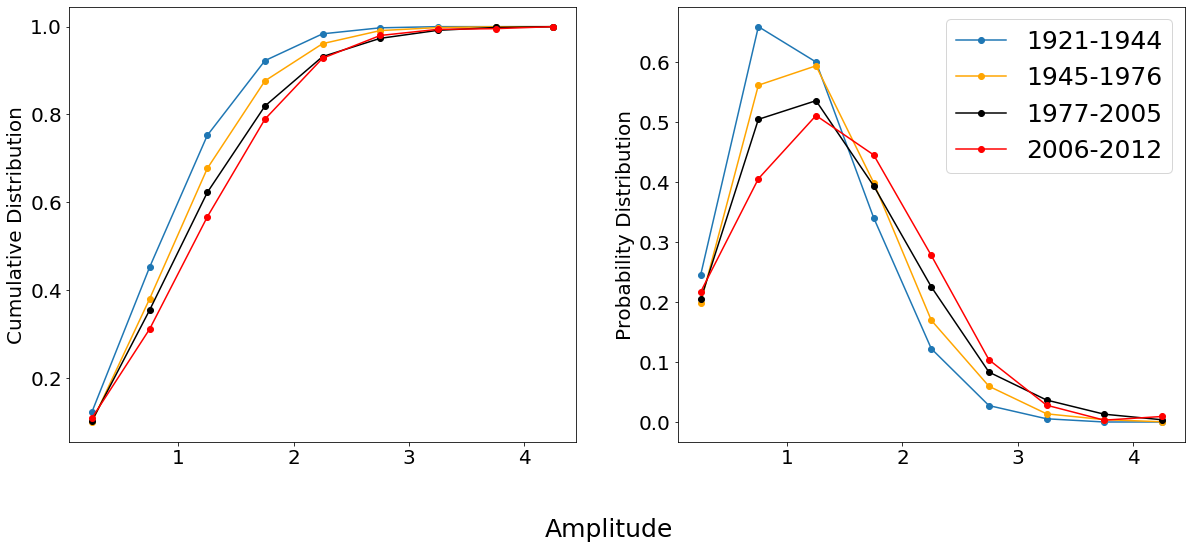

In [24]:
fig,ax=plt.subplots(1,2,figsize=(20,8))

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 25
plt.rcParams['image.cmap'] = 'seismic'


bin_centers = 0.5*(x1_1[1:]+x1_1[:-1])
ax[0].plot(bin_centers,np.nanmean(n11,0)[0,:],'-o',label='1921-1944')
ax[0].plot(bin_centers,np.nanmean(n11,0)[1,:],'-o',color='orange',label='1945-1976')
ax[0].plot(bin_centers,np.nanmean(n11,0)[2,:],'-ko',label='1977-2005')
ax[0].plot(bin_centers,np.nanmean(n11,0)[3,:],'-o',color='r',label='2006-2012')
ax[0].set_ylabel('Cumulative Distribution')

ax[1].plot(bin_centers,np.nanmean(n22,0)[0,:],'-o',label='1921-1944')
ax[1].plot(bin_centers,np.nanmean(n22,0)[1,:],'-o',color='orange',label='1945-1976')
ax[1].plot(bin_centers,np.nanmean(n22,0)[2,:],'-ko',label='1977-2005')
ax[1].plot(bin_centers,np.nanmean(n22,0)[3,:],'-o',color='r',label='2006-2012')
ax[1].set_ylabel('Probability Distribution')

plt.legend()
# bin_centers3 = 0.5*(x3[1:]+x3[:-1])
# plt.plot(bin_centers3,n3,'b',label='oliver')
# plt.legend(bbox_to_anchor=(0.6,-0.38),loc="lower right",ncol=5)
fig.text(0.5, -0.04, 'Amplitude', ha='center')
# fig.text(0.04, 0.5, 'CDF', va='center', rotation='vertical')
fig.savefig('/home/cccr/supriyo/panini/very_low_jgrjd_figure7.png',dpi=300,bbox_inches='tight')

In [25]:
%store n11
%store n22
%store x1_1

Stored 'n11' (ndarray)
Stored 'n22' (ndarray)
Stored 'x1_1' (ndarray)
